# Lightweight image generation with aMUSEd and OpenVINO

[Amused](https://huggingface.co/docs/diffusers/api/pipelines/amused) is a lightweight text to image model based off of the [muse](https://arxiv.org/pdf/2301.00704.pdf) architecture. Amused is particularly useful in applications that require a lightweight and fast model such as generating many images quickly at once.

Amused is a VQVAE token based transformer that can generate an image in fewer forward passes than many diffusion models. In contrast with muse, it uses the smaller text encoder CLIP-L/14 instead of t5-xxl. Due to its small parameter count and few forward pass generation process, amused can generate many images quickly. This benefit is seen particularly at larger batch sizes.

<img src="https://huggingface.co/amused/amused-256/resolve/main/assets/collage_small.png" width="800" height="800"> 


#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Load and run the original pipeline](#Load-and-run-the-original-pipeline)
- [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR)
    - [Convert the Text Encoder](#Convert-the-Text-Encoder)
    - [Convert the U-ViT transformer](#Convert-the-U-ViT-transformer)
    - [Convert VQ-GAN decoder (VQVAE)](#Convert-VQ-GAN-decoder-(VQVAE))
- [Compiling models and prepare pipeline](#Compiling-models-and-prepare-pipeline)
- [Interactive inference](#Interactive-inference)

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "diffusers>=0.25.0" "openvino>=2023.2.0" "accelerate>=0.20.3" gradio torch --extra-index-url https://download.pytorch.org/whl/cpu

## Load and run the original pipeline
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import torch
from diffusers import AmusedPipeline


pipe = AmusedPipeline.from_pretrained(
    "amused/amused-256",
)

prompt = "kind smiling ghost"
image = pipe(prompt, generator=torch.Generator('cpu').manual_seed(8)).images[0]
image.save('text2image_256.png')

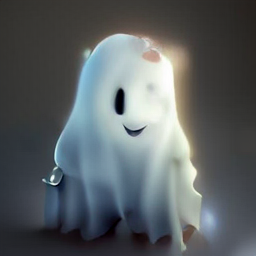

In [2]:
image

## Convert the model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

aMUSEd consists of three separately trained components: a pre-trained CLIP-L/14 text encoder, a VQ-GAN, and a U-ViT.

![image_png](https://cdn-uploads.huggingface.co/production/uploads/5dfcb1aada6d0311fd3d5448/97ca2Vqm7jBfCAzq20TtF.png)

During inference, the U-ViT is conditioned on the text encoder’s hidden states and iteratively predicts values for all masked tokens. The cosine masking schedule determines a percentage of the most confident token predictions to be fixed after every iteration. After 12 iterations, all tokens have been predicted and are decoded by the VQ-GAN into image pixels.

Define paths for converted models:

In [3]:
from pathlib import Path


TRANSFORMER_OV_PATH = Path('models/transformer_ir.xml')
TEXT_ENCODER_OV_PATH = Path('models/text_encoder_ir.xml')
VQVAE_OV_PATH = Path('models/vqvae_ir.xml')

Define the conversion function for PyTorch modules. We use `ov.convert_model` function to obtain OpenVINO Intermediate Representation object and `ov.save_model` function to save it as XML file.

In [4]:
import torch

import openvino as ov


def convert(model: torch.nn.Module, xml_path: str, example_input):
    xml_path = Path(xml_path)
    if not xml_path.exists():
        xml_path.parent.mkdir(parents=True, exist_ok=True)
        with torch.no_grad():
            converted_model = ov.convert_model(model, example_input=example_input)
        ov.save_model(converted_model, xml_path, compress_to_fp16=False)
        
        # cleanup memory
        torch._C._jit_clear_class_registry()
        torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
        torch.jit._state._clear_class_state()

### Convert the Text Encoder
[back to top ⬆️](#Table-of-contents:)

In [5]:
class TextEncoderWrapper(torch.nn.Module):
    def __init__(self, text_encoder):
        super().__init__()
        self.text_encoder = text_encoder

    def forward(self, input_ids=None, return_dict=None, output_hidden_states=None):
        
        outputs = self.text_encoder(
            input_ids=input_ids,
            return_dict=return_dict,
            output_hidden_states=output_hidden_states, 
        )

        return outputs.text_embeds, outputs.last_hidden_state, outputs.hidden_states


input_ids = pipe.tokenizer(
    prompt,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=pipe.tokenizer.model_max_length,
)

input_example = {
    'input_ids': input_ids.input_ids,
    'return_dict': torch.tensor(True), 
    'output_hidden_states': torch.tensor(True)
}

convert(TextEncoderWrapper(pipe.text_encoder), TEXT_ENCODER_OV_PATH, input_example)

### Convert the U-ViT transformer
[back to top ⬆️](#Table-of-contents:)

In [6]:
class TransformerWrapper(torch.nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.transformer = transformer

    def forward(self, latents=None, micro_conds=None, pooled_text_emb=None, encoder_hidden_states=None):
        
        return self.transformer(
            latents,
            micro_conds=micro_conds, 
            pooled_text_emb=pooled_text_emb, 
            encoder_hidden_states=encoder_hidden_states,
        )


shape = (1, 16, 16)
latents = torch.full(
    shape, pipe.scheduler.config.mask_token_id, dtype=torch.long
)
latents = torch.cat([latents] * 2)


example_input = {
    'latents': latents,
    'micro_conds': torch.rand([2, 5], dtype=torch.float32),
    'pooled_text_emb': torch.rand([2, 768], dtype=torch.float32),
    'encoder_hidden_states': torch.rand([2, 77, 768], dtype=torch.float32), 
}


pipe.transformer.eval()
w_transformer = TransformerWrapper(pipe.transformer)
convert(w_transformer, TRANSFORMER_OV_PATH, example_input)

### Convert VQ-GAN decoder (VQVAE)
[back to top ⬆️](#Table-of-contents:)
Function `get_latents` is needed to return real latents for the conversion. Due to the VQVAE implementation autogenerated tensor of the required shape is not suitable. This function repeats part of `AmusedPipeline`.

In [7]:
def get_latents():
    shape = (1, 16, 16)
    latents = torch.full(
        shape, pipe.scheduler.config.mask_token_id, dtype=torch.long
    )
    model_input = torch.cat([latents] * 2)
    
    
    model_output = pipe.transformer(
        model_input,
        micro_conds=torch.rand([2, 5], dtype=torch.float32),
        pooled_text_emb=torch.rand([2, 768], dtype=torch.float32),
        encoder_hidden_states=torch.rand([2, 77, 768], dtype=torch.float32),
    )
    guidance_scale = 10.0
    uncond_logits, cond_logits = model_output.chunk(2)
    model_output = uncond_logits + guidance_scale * (cond_logits - uncond_logits)
    
    
    latents = pipe.scheduler.step(
        model_output=model_output,
        timestep=torch.tensor(0),
        sample=latents,
    ).prev_sample

    return latents


class VQVAEWrapper(torch.nn.Module):
    def __init__(self, vqvae):
        super().__init__()
        self.vqvae = vqvae

    def forward(self, latents=None, force_not_quantize=True, shape=None):
        outputs = self.vqvae.decode(
            latents,
            force_not_quantize=force_not_quantize,
            shape=shape.tolist(), 
        )

        return outputs


latents = get_latents()
example_vqvae_input = {
    'latents': latents,
    'force_not_quantize': torch.tensor(True),
    'shape': torch.tensor((1, 16, 16, 64))
}

convert(VQVAEWrapper(pipe.vqvae), VQVAE_OV_PATH, example_vqvae_input)

## Compiling models and prepare pipeline
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

In [8]:
import ipywidgets as widgets


core = ov.Core()
DEVICE = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

DEVICE

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [9]:
ov_text_encoder = core.compile_model(TEXT_ENCODER_OV_PATH, DEVICE.value)
ov_transformer = core.compile_model(TRANSFORMER_OV_PATH, DEVICE.value)
ov_vqvae = core.compile_model(VQVAE_OV_PATH, DEVICE.value)

Let's create callable wrapper classes for compiled models to allow interaction with original `AmusedPipeline` class. Note that all of wrapper classes return `torch.Tensor`s instead of `np.array`s.


In [10]:
from collections import namedtuple


class ConvTextEncoderWrapper(torch.nn.Module):
    def __init__(self, text_encoder, config):
        super().__init__()
        self.config = config
        self.text_encoder = text_encoder

    def forward(self, input_ids=None, return_dict=None, output_hidden_states=None):
        inputs = {
            'input_ids': input_ids,
            'return_dict': return_dict,
            'output_hidden_states': output_hidden_states
        }
        
        outs = self.text_encoder(inputs)

        outputs = namedtuple('CLIPTextModelOutput', ('text_embeds', 'last_hidden_state', 'hidden_states'))
        
        text_embeds = torch.from_numpy(outs[0])
        last_hidden_state = torch.from_numpy(outs[1])
        hidden_states = list(torch.from_numpy(out) for out in outs.values())[2:]
        
        return outputs(text_embeds, last_hidden_state, hidden_states)

In [11]:
class ConvTransformerWrapper(torch.nn.Module):
    def __init__(self, transformer, config):
        super().__init__()
        self.config = config
        self.transformer = transformer

    def forward(self, latents=None, micro_conds=None, pooled_text_emb=None, encoder_hidden_states=None, **kwargs):
        outputs = self.transformer(
            {
                'latents': latents,
                'micro_conds': micro_conds, 
                'pooled_text_emb': pooled_text_emb, 
                'encoder_hidden_states': encoder_hidden_states,
            },
            share_inputs=False
        )

        return torch.from_numpy(outputs[0])

In [12]:
class ConvVQVAEWrapper(torch.nn.Module):
    def __init__(self, vqvae, dtype, config):
        super().__init__()
        self.vqvae = vqvae
        self.dtype = dtype
        self.config = config

    def decode(self, latents=None, force_not_quantize=True, shape=None):
        inputs = {
            'latents': latents,
            'force_not_quantize': force_not_quantize,
            'shape': torch.tensor(shape)
        }
        
        outs = self.vqvae(inputs)
        outs = namedtuple('VQVAE', 'sample')(torch.from_numpy(outs[0]))
        
        return outs

And insert wrappers instances in the pipeline:

In [ ]:
prompt = "kind smiling ghost"

transformer = pipe.transformer
vqvae = pipe.vqvae
text_encoder = pipe.text_encoder

pipe.__dict__["_internal_dict"]['_execution_device'] = pipe._execution_device  # this is to avoid some problem that can occur in the pipeline 
pipe.register_modules(
    text_encoder=ConvTextEncoderWrapper(ov_text_encoder, text_encoder.config),
    transformer=ConvTransformerWrapper(ov_transformer, transformer.config),
    vqvae=ConvVQVAEWrapper(ov_vqvae, vqvae.dtype, vqvae.config),
)

image = pipe(prompt, generator=torch.Generator('cpu').manual_seed(8)).images[0]
image.save('text2image_256.png')

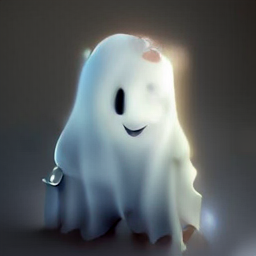

In [14]:
image

## Interactive inference
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import numpy as np
import gradio as gr


def generate(prompt, seed, _=gr.Progress(track_tqdm=True)):
    image = pipe(prompt, generator=torch.Generator('cpu').manual_seed(seed)).images[0]
    return image


demo = gr.Interface(
    generate,
    [
        gr.Textbox(label="Prompt"),
        gr.Slider(0, np.iinfo(np.int32).max, label="Seed")
    ],
    "image",
    examples=[
        ["happy snowman", 88],
        ["green ghost rider", 0],
        ["kind smiling ghost", 8],
    ],
    allow_flagging="never",
)
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/